In [94]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import math

In [154]:
class SpatialPooler:
    def __init__(self, input_size, w=10, h=10):
        self.input_size = input_size                # input vector 크기
        self.column_w = w                           # column 의 가로 크기
        self.column_h = h                           # column 의 세로 크기
        self.connectedPerm = .5                     # synapse 활성화(1) 될 permanence 임계치
        self.min_overlap = 5                        # 발화 하기 위한 컬럼 당 최소한의 overlap count
        self.minLocalActivity = 0                   # 승리하기 위해 겹쳐야하는 최소 overlap 수
        self.desiredLocalActivity = 1               # 승리할 column 수
        self.minDutyCycle = 0                       # column 당 최소 발화 duty
        self.permanence_inc = .01                   # 학습시 permanence 증가량
        self.permanence_dec = .01                   # 학습시 permanence 감소량
        self.step = 0
        
        self.columns2D = np.random.rand(self.column_w, self.input_size, self.column_h) # permanence ndarry. 초기화 필요      
        self.columns2D_avail = np.zeros([self.column_w, self.input_size, self.column_h]) # 모든 셀들의 연결 유무 정보
        self.boosts2D = np.ones([self.column_w, self.column_h])                    # 보정에 필요한 boost 
        self.overlapped = np.zeros([self.column_w, self.column_h])
        self.SDRs = np.zeros([self.column_w, self.column_h])                       # 최종적으로 생성될 SDRs
        self.activeColumns = []                                                    # active 된 column 인덱스들의 집합
        self.activeHistory = []                                                    # active duty 를 계산하기 위한 active 기록
        self.overlapHistory = []                                                   # overlap duty 를 계산하기 위한 overlap 기록
        self.activeDutyInfo = np.zeros([self.column_w, self.column_h])             # active duty 정보
        self.overlapDutyInfo = np.zeros([self.column_w, self.column_h])            # overlap duty 정보
        
        ## duty 계산을 위한 history 생성 ##
        for w in range(self.column_w):
            self.activeHistory.append([])
            self.overlapHistory.append([])
            
            for h in range(self.column_h):
                self.activeHistory[w].append(collections.deque())
                self.overlapHistory[w].append(collections.deque())
                
    ''' SDR 생성 '''
    def compute_SDR(self, input_data):
        
        ## 1. overlaping ##
        for w in range(self.column_w):
            for h in range(self.column_h):
                for s in range(self.input_size):
                    if(self.columns2D[w][s][h] > self.connectedPerm):
                        self.columns2D_avail[w][s][h] = 1
                    else:
                        self.columns2D_avail[w][s][h] = 0                
                
        self.overlapped = input_data @ self.columns2D_avail
        #print(self.overlapped)
        
        for w in range(self.column_w):
            for h in range(self.column_h):
                if(self.overlapped[w][h] > self.min_overlap):
                    self.overlapped[w][h] *= self.boosts2D[w][h]
                    
                    if(len(self.overlapHistory[w][h]) > 100):
                        self.overlapHistory[w][h].popleft()
                        
                    self.overlapHistory[w][h].append(True)
                    
                else:
                    self.overlapped[w][h] = 0
                    
                    if(len(self.overlapHistory[w][h]) > 100):
                        self.overlapHistory[w][h].popleft()
                        
                    self.overlapHistory[w][h].append(False)
                    
                    
        ## 2. inhibition ##
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.minLocalActivity = self.kthScore(w, h, self.desiredLocalActivity)
                #print("min :", self.minLocalActivity)
                
                if(self.overlapped[w][h] > self.minLocalActivity and (w, h) not in self.activeColumns):
                    self.activeColumns.append((w, h))
                    
                    if(len(self.activeHistory[w][h]) > 100):
                        self.activeHistory[w][h].popleft()
                        
                    self.activeHistory[w][h].append(True)
                    
                else:
                    if(len(self.activeHistory[w][h]) > 100):
                        self.activeHistory[w][h].popleft()
                        
                    self.activeHistory[w][h].append(False)
                    
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.SDRs[w][h] = 0
        
        for w, h in self.activeColumns:
            self.SDRs[w][h] = 1
                
                
        ## 3. learning ##
        for w, h in self.activeColumns:
            for s in range(self.input_size):
                if(self.columns2D[w][s][h] > self.connectedPerm):
                    self.columns2D[w][s][h] += self.permanence_inc
                else:
                    self.columns2D[w][s][h] -= self.permanence_dec
                    
                    
                    
        ## 3.2. 보정 작업 ##
        self.update_activeDuty()
        self.update_overlapDuty()
        self.step += 1
        
        for w in range(self.column_w):
            for h in range(self.column_h):
                if(self.step > 100):
                    ## 자주 승리하지 못하는 column 에 대하여 잘 발화할 수 있도록 boost 시켜줌
                    self.minDutyCycle = .01 * self.maxDutyCycle(w, h)
                    self.boostFunction(w, h, .01)

                    ## input 과 잘 겹치지 않는 synapse 에 대해서 permanence 증가시켜줌
                    if(self.overlapDutyInfo[w][h] < self.minDutyCycle):
                        self.increase_Permanence(w, h)
                        #print("min", self.minDutyCycle)
                        
    ''' 억제 반경 내 승리할 컬럼의 기준 '''
    def kthScore(self, w, h, desired_kth):
        score = self.input_size / 10
        radius = self.overlapped[w][h] / self.boosts2D[w][h]  # 임시적인 억제 반경 계산
        
        l = int(max(w - radius, 0))
        r = int(min(w + radius, self.column_w))
        d = int(max(h - radius, 0))
        u = int(min(h + radius, self.column_h))
        #print("rad :",radius)
        
        partial = np.sort(self.overlapped[l : r, d : u])
        partial.shape = -1

        if(desired_kth < len(partial)):
            score = partial[-desired_kth]
        
        return score
    
    
    ''' 억제 반경 내 가장 자주 승리한 컬럼의 duty '''
    def maxDutyCycle(self, w, h):
        maxDuty = .05
        radius = self.overlapped[w][h]  # 임시적인 억제 반경 계산
        
        if(int(w-radius)>=0 and int(w+radius)<self.column_w and int(h-radius)>=0 and int(h+radius)<self.column_h):
            partial = np.sort(self.activeDutyInfo[int(w-radius) : int(w+radius), int(h-radius) : int(h+radius)])
            partial.shape = -1
            
            if(len(partial) > 0):
                maxDuty = partial[-1]
        
        return maxDuty
    
    
    ''' 해당 column 이 발화하도록 격려 '''
    def boostFunction(self, w, h, boost):
        if(self.activeDutyInfo[w][h] < self.minDutyCycle):
            self.boosts2D[w][h] += boost
            
            
    ''' 해당 column 의 모든 셀의 synapse 의 permanence 를 증가시켜 잘 겹치도록 격려 '''
    def increase_Permanence(self, w, h):
        self.columns2D[w, :, h] += self.permanence_inc
        
        
    ''' activeDuty update '''
    def update_activeDuty(self):
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.activeDutyInfo[w][h] = np.sum(self.activeHistory[w][h]) / 100

                
    ''' overlapDuty update '''
    def update_overlapDuty(self):
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.overlapDutyInfo[w][h] = np.sum(self.overlapHistory[w][h]) / 100
    
    def visualize_SDR(self):
        plt.imshow(self.SDRs)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        plt.colorbar(cax=cax)
        plt.show()
        
        print(len(self.activeColumns)/(self.column_w*self.column_h))

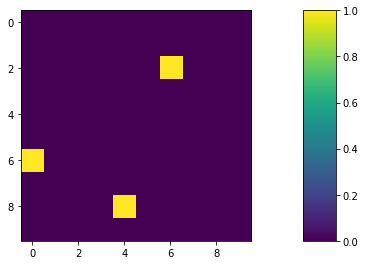

0.03


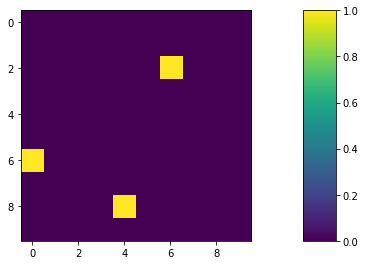

0.03


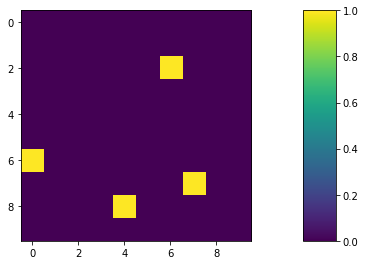

0.04


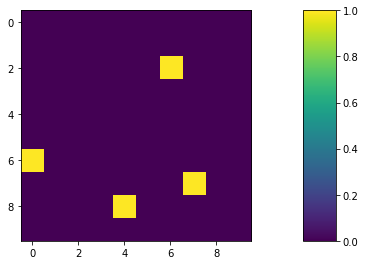

0.04


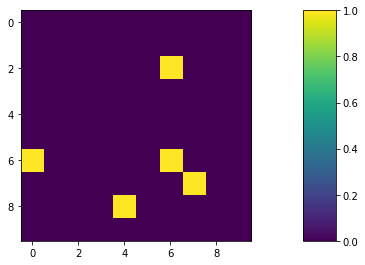

0.05


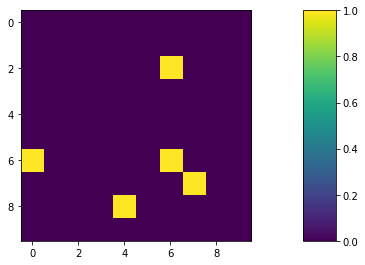

0.05


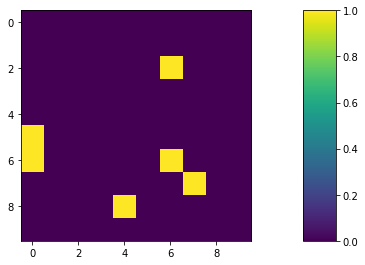

0.06


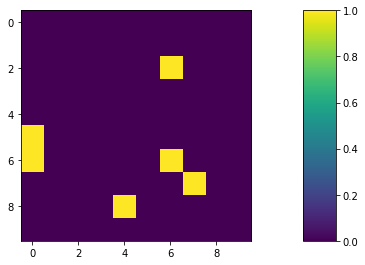

0.06


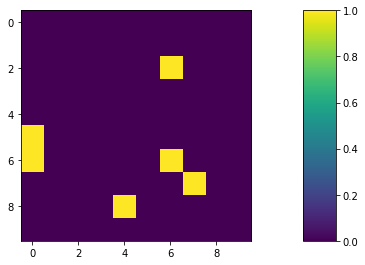

0.06


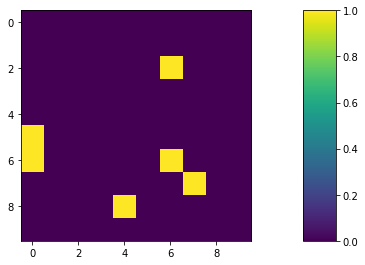

0.06


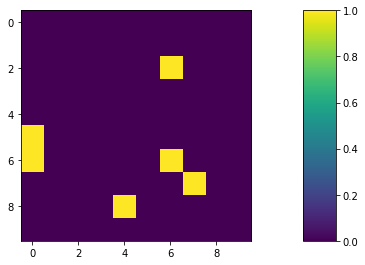

0.06


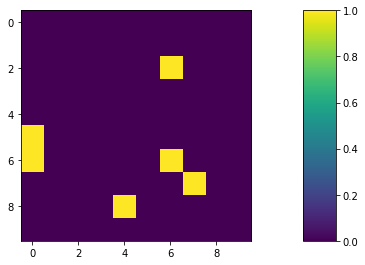

0.06


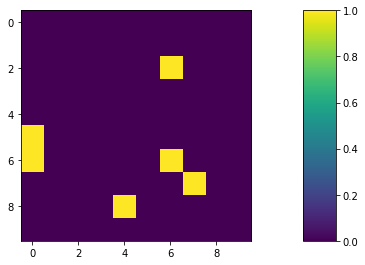

0.06


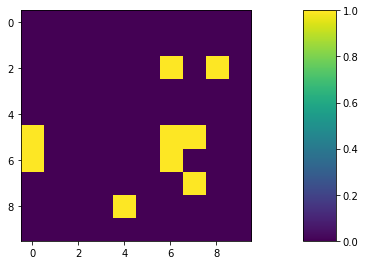

0.09


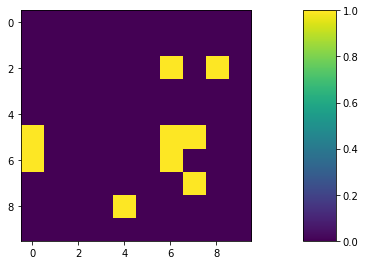

0.09


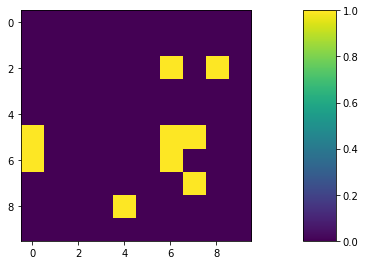

0.09


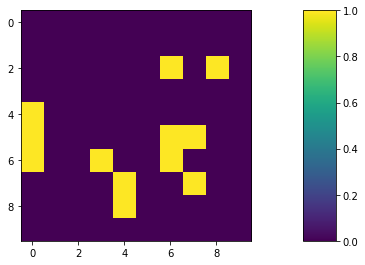

0.12


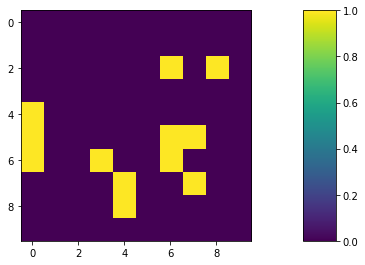

0.12


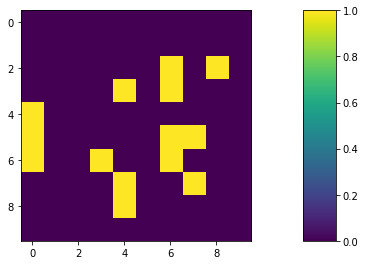

0.14


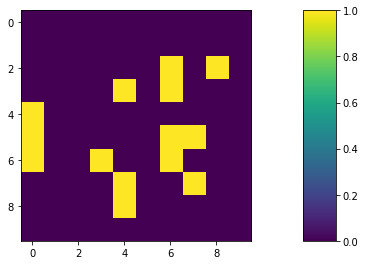

0.14


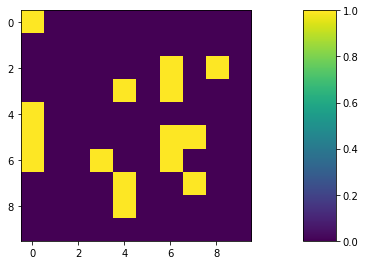

0.15


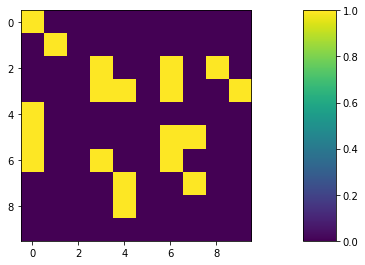

0.19


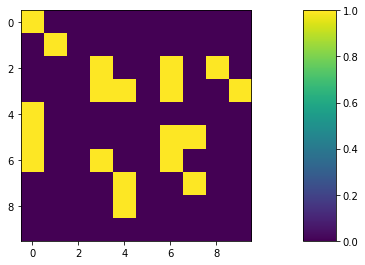

0.19


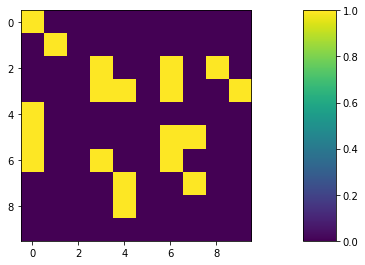

0.19


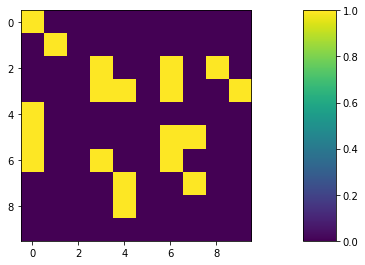

0.19


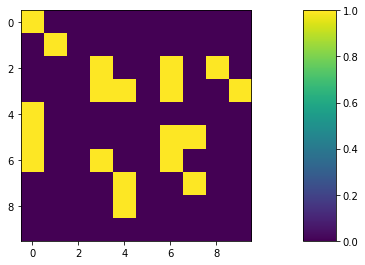

0.19


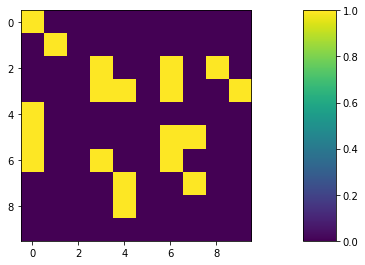

0.19


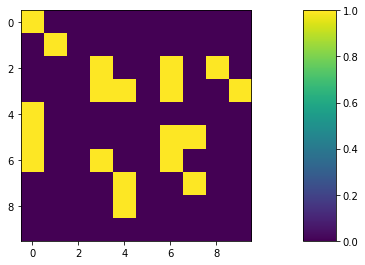

0.19


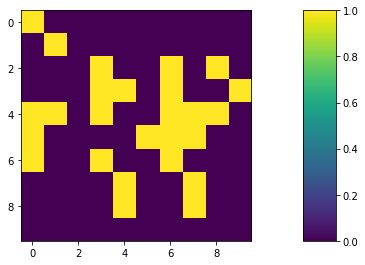

0.26


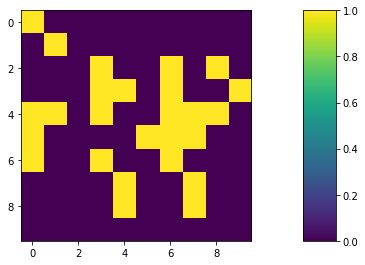

0.26


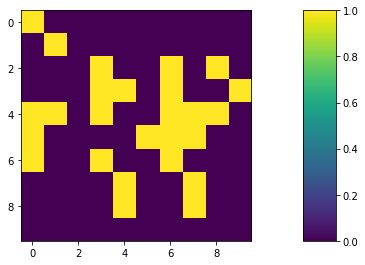

0.26


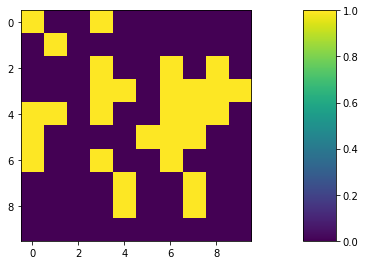

0.29


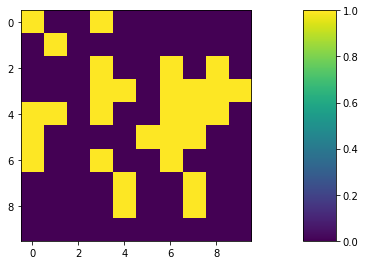

0.29


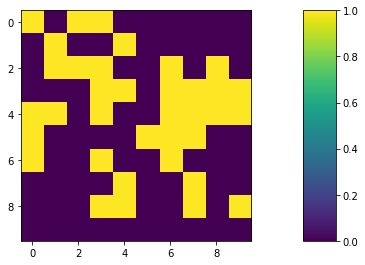

0.36


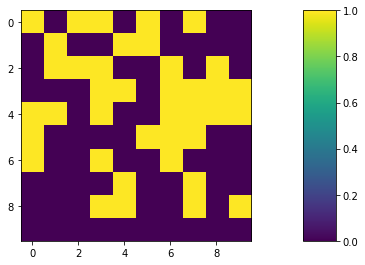

0.39


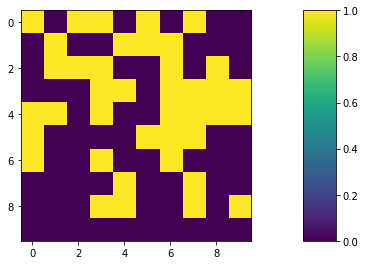

0.4


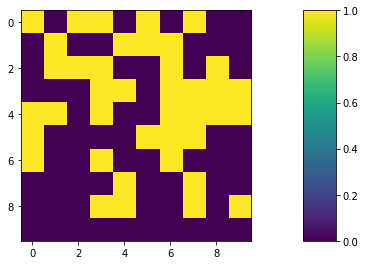

0.4


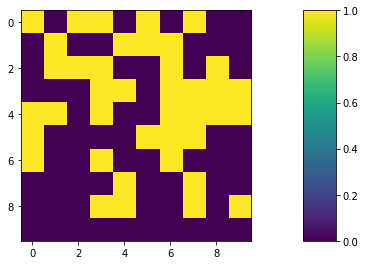

0.4


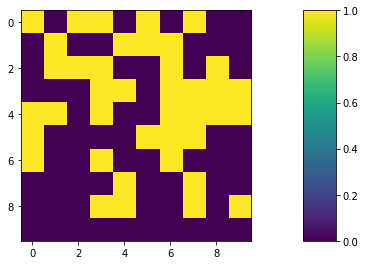

0.4


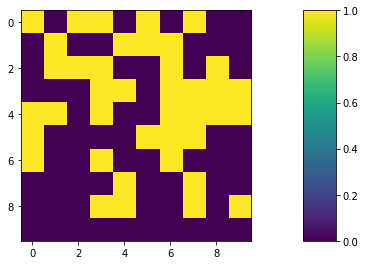

0.4


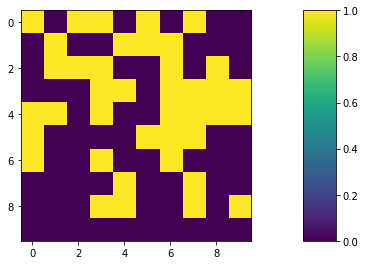

0.4


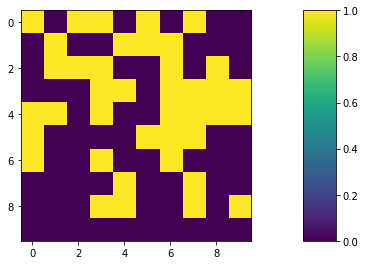

0.4


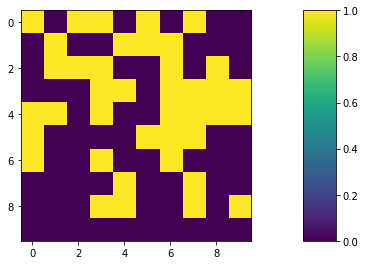

0.4


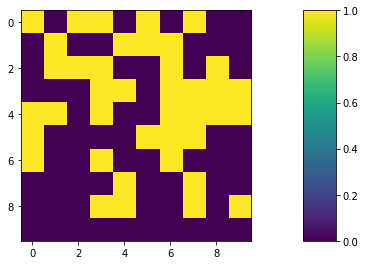

0.4


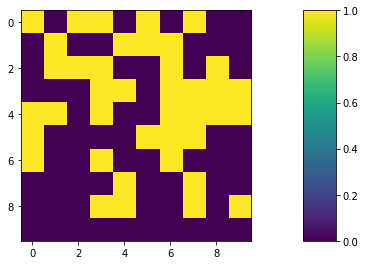

0.4


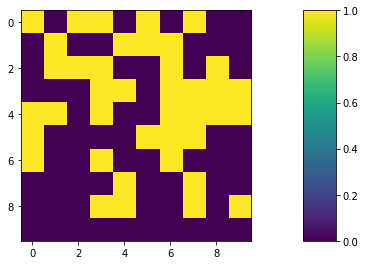

0.4


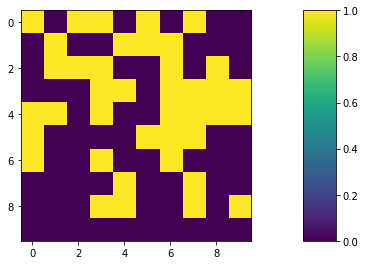

0.4


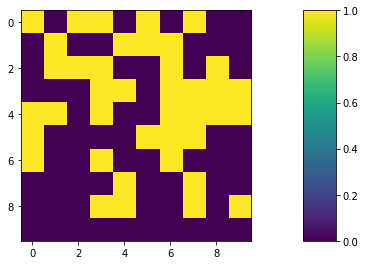

0.4


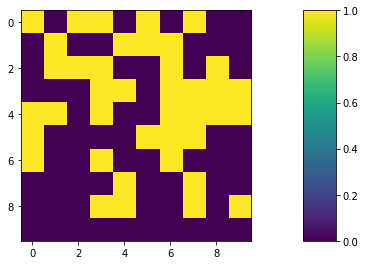

0.4


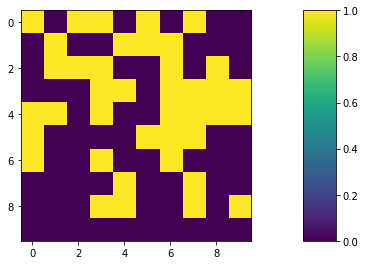

0.4


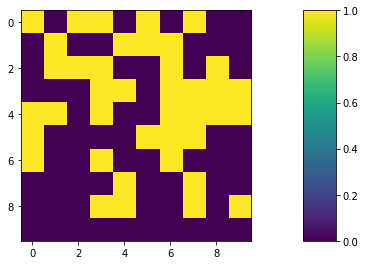

0.4


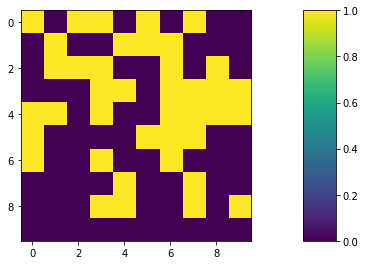

0.4


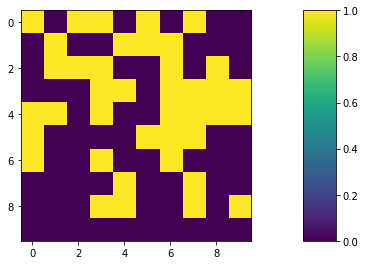

0.4


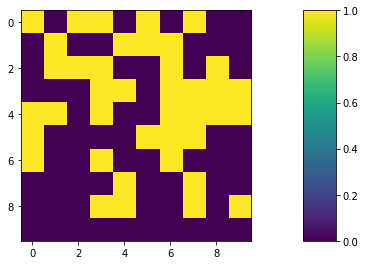

0.4


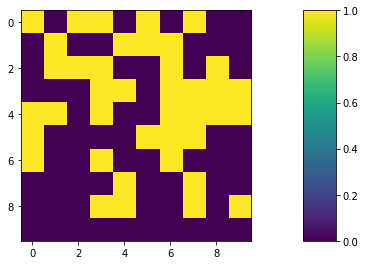

0.4


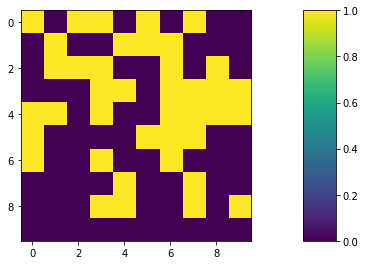

0.4


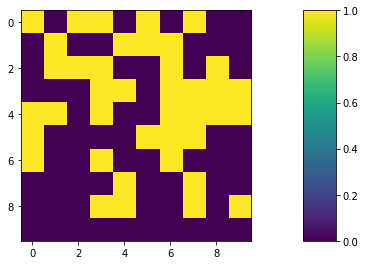

0.4


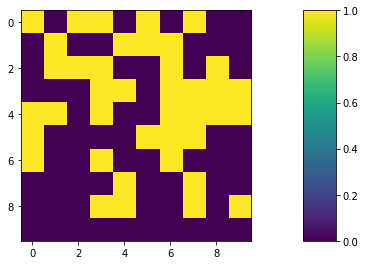

0.4


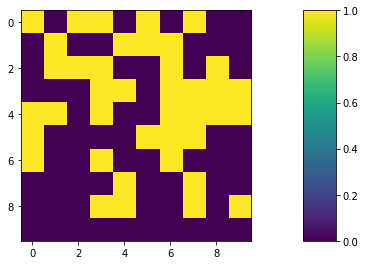

0.4


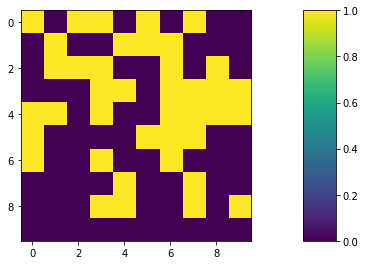

0.4


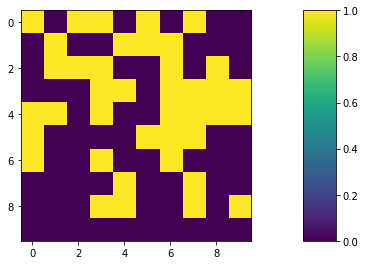

0.4


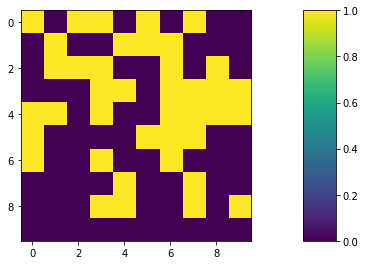

0.4


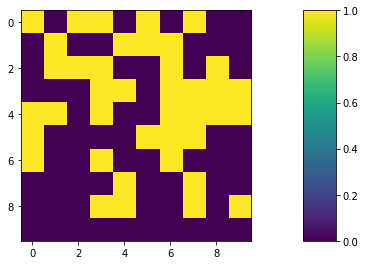

0.4


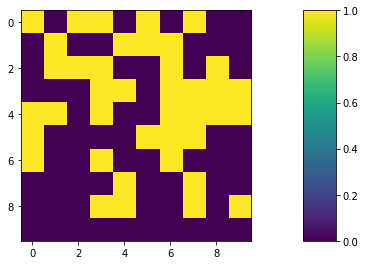

0.4


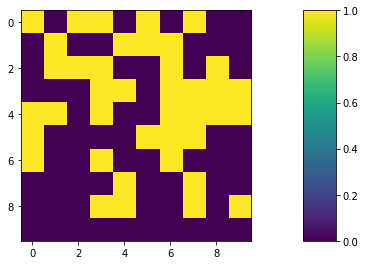

0.4


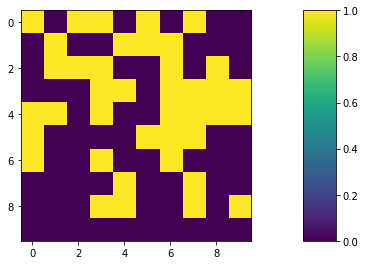

0.4


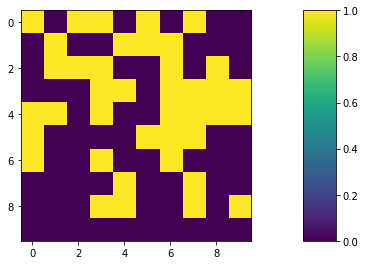

0.4


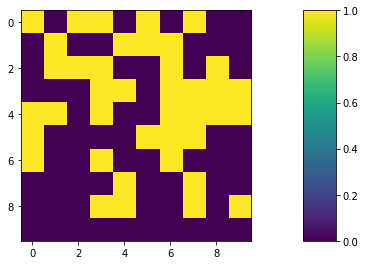

0.4


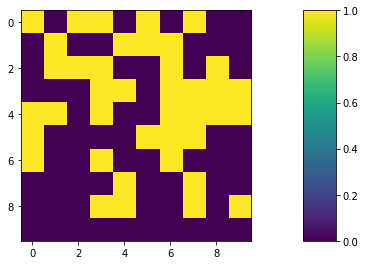

0.4


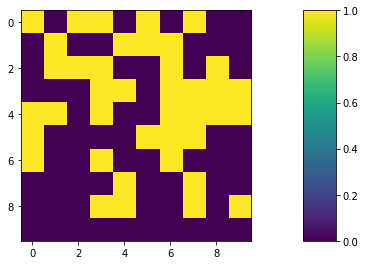

0.4


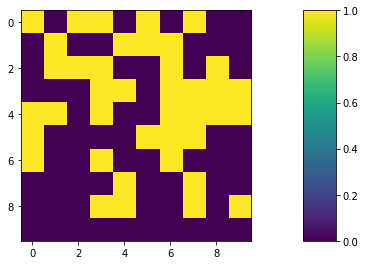

0.4


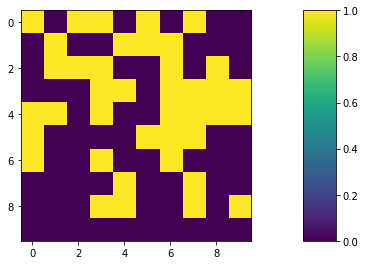

0.4


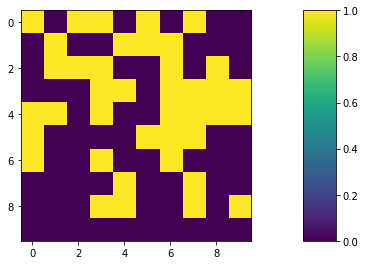

0.4


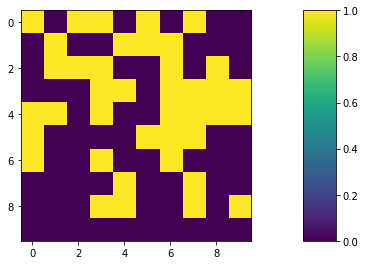

0.4


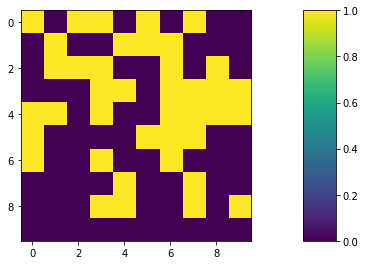

0.4


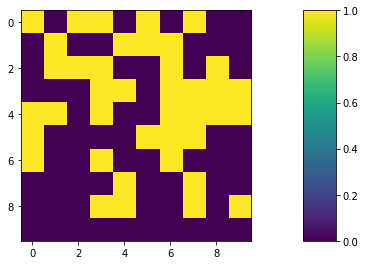

0.4


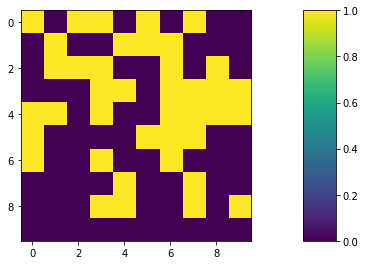

0.4


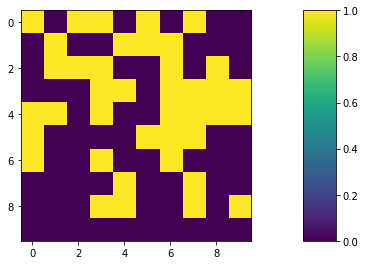

0.4


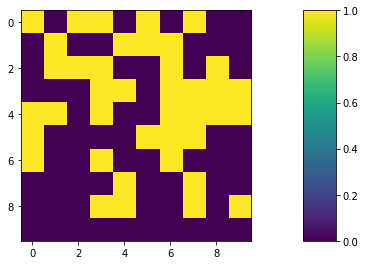

0.4


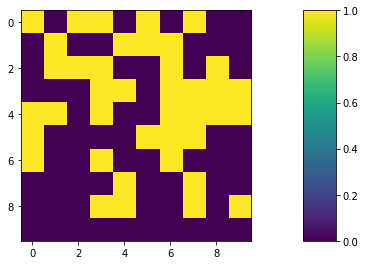

0.4


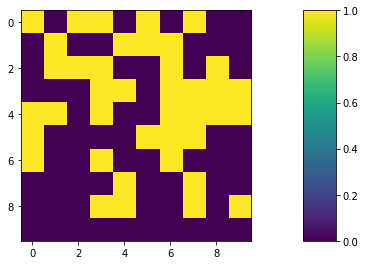

0.4


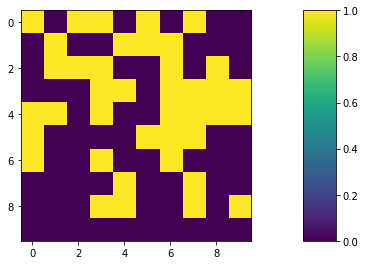

0.4


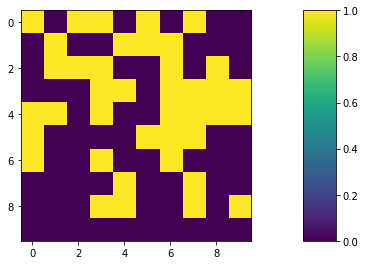

0.4


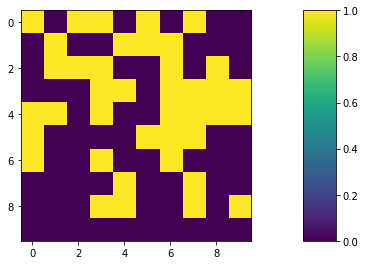

0.4


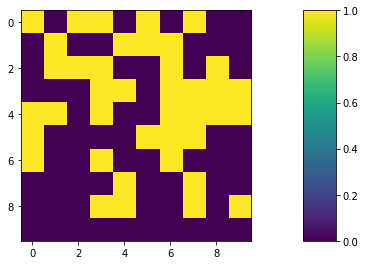

0.4


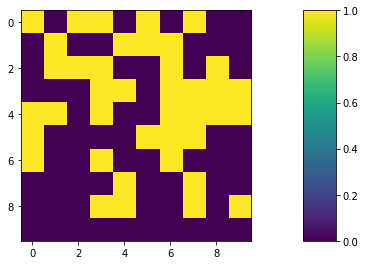

0.4


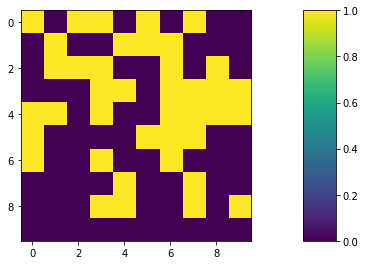

0.4


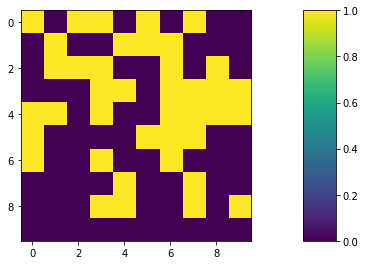

0.4


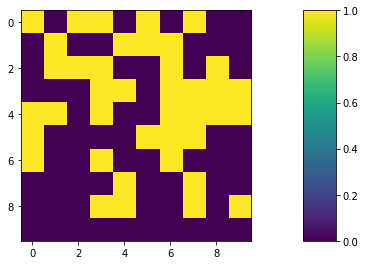

0.4


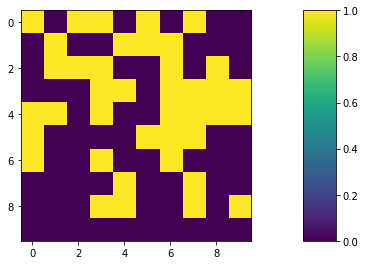

0.4


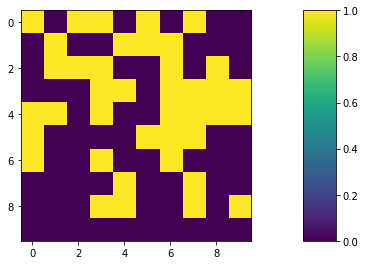

0.4


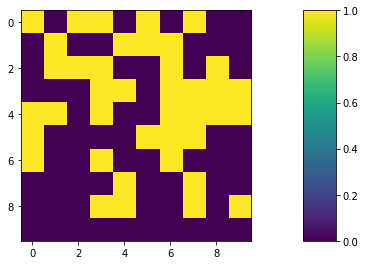

0.4


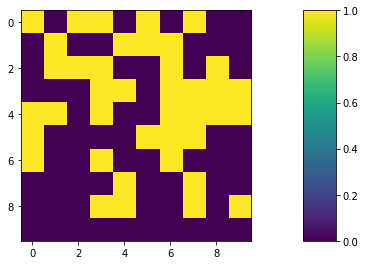

0.4


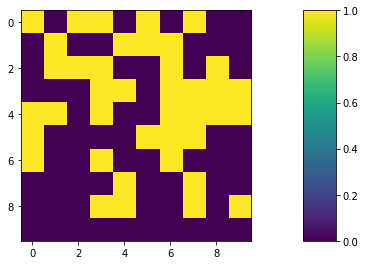

0.4


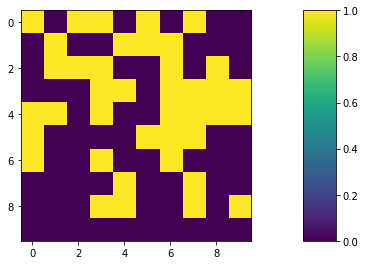

0.4


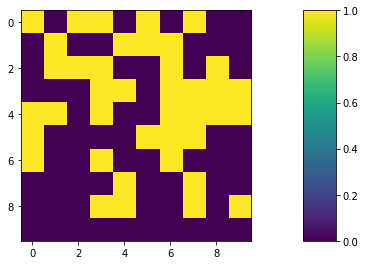

0.4


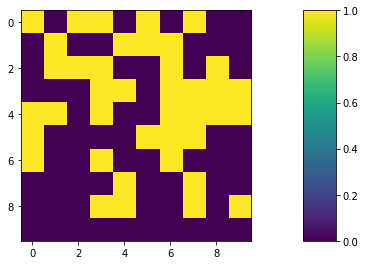

0.4


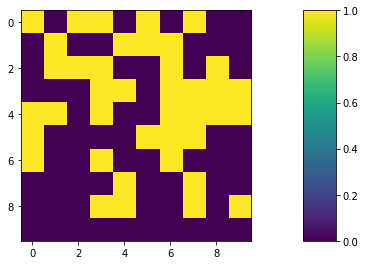

0.4


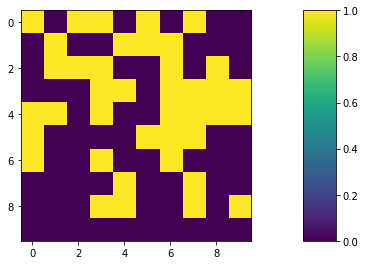

0.4


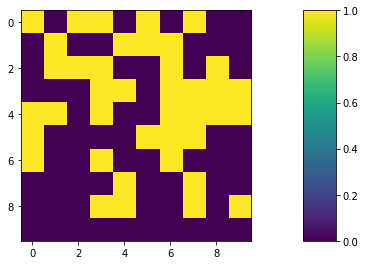

0.4


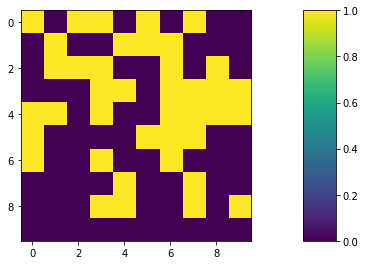

0.4


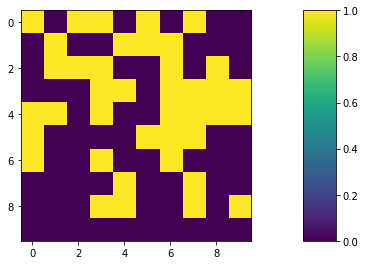

0.4


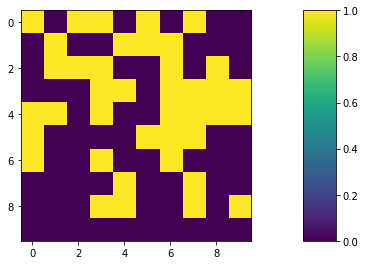

0.4


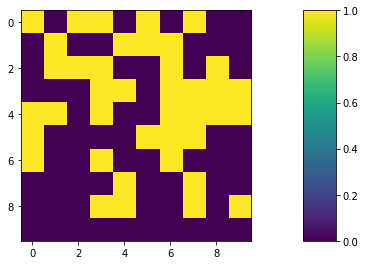

0.4


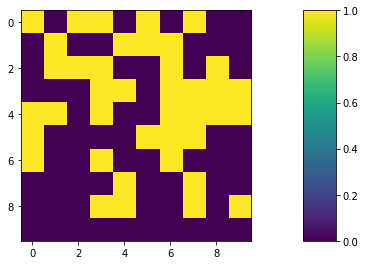

0.4


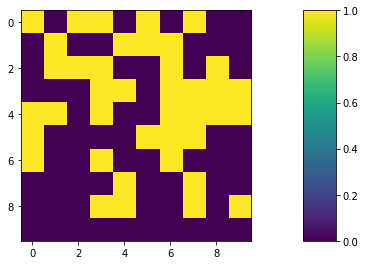

0.4


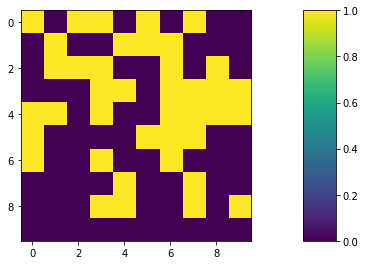

0.4


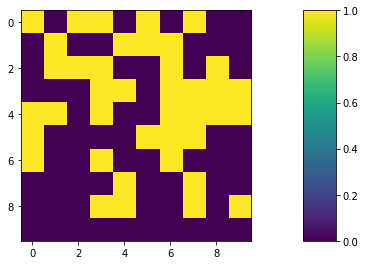

0.4


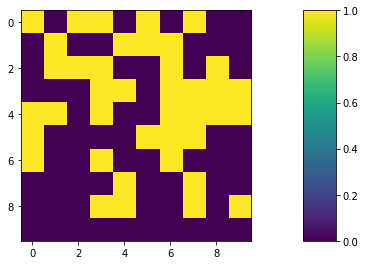

0.4


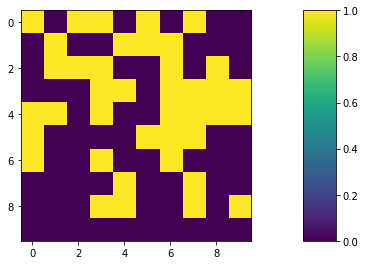

0.4


KeyboardInterrupt: 

In [156]:
#-- 1. sort 1열로 됨?
#-- 2. 행렬 곱 테스트 3d array
#-- 3. KthScore 정렬 잘 될까
# 4. 학습과 보정이 잘 진행되는지 확인
# 5. 제대로 된 data 주입해보기
# 같은 데이터를 집어넣으니까 보정 작업에서 발산한다.
# 그것보다 duty 계산 보정을 해야한다.

import random

a1 = np.array([1,1,0,0,0,1,1,1,0,1])
a2 = np.array([1,1,0,1,1,1,0,0,0,1])
a3 = np.array([0,1,0,0,1,0,1,1,0,0])
a4 = np.array([1,0,1,1,1,1,0,1,0,0])
lst = [a1, a2, a3, a4]
sp = SpatialPooler(10,10,10)
cnt = 0
for _ in range(500):
    r = random.randrange(0,3)
    sp.compute_SDR(lst[r])
    if(sp.step > 100):
        sp.visualize_SDR()
    cnt += 1

In [28]:
a = np.arange(3)
b = np.array([1,3,2,4,2,1,2,4,2,1,2,3]).reshape(2,3,2)
c = collections.deque()
c.append(True)
c.append(True)
c.append(True)
np.sum(c)

3

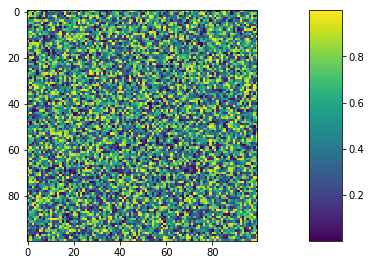

In [10]:
a = plt.imshow(np.random.rand(100,100))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()